<a href="https://colab.research.google.com/github/Sravya106/Cat-vs-Dog-Classification/blob/main/CatvsDog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Resizing, Rescaling, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.image import flip_up_down, flip_left_right
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Fetching data from Kaggle


In [ ]:
val_directroy = "/content/dataset/test"
train_directroy = "/content/dataset/train"
CLASS_NAMES = ["cats", "dogs"]

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

 76% 49.0M/64.4M [00:00<00:00, 127MB/s]
100% 64.4M/64.4M [00:00<00:00, 151MB/s]


In [ ]:
!unzip "/content/cats-and-dogs-image-classification.zip" -d "/content/dataset"

In [ ]:
train_data = image_dataset_from_directory(
    train_directroy,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 557 files belonging to 2 classes.


In [ ]:
val_data = image_dataset_from_directory(
    val_directroy,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 140 files belonging to 2 classes.


# Visualization if data

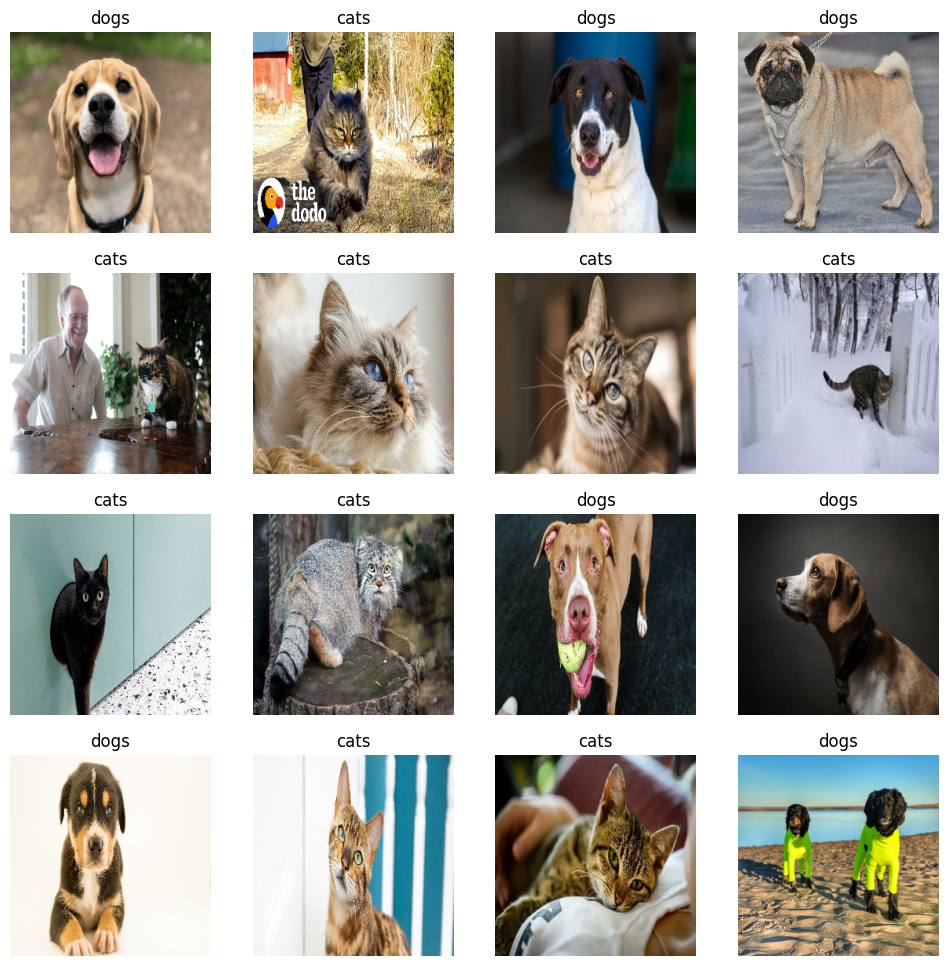

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in train_data.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i] / 255)
      plt.title(CLASS_NAMES[tf.argmax(labels[i], axis=0).numpy()])
      plt.axis("off")

plt.show()

In [ ]:
num_cats = 0
num_dogs = 0


for images, labels in train_data:
    labels = labels.numpy()

    num_cats += sum(labels == 0)
    num_dogs += sum(labels == 1)


print(f"Number of cat images: {num_cats}")
print(f"Number of dog images: {num_dogs}")

Number of cat images: 279
Number of dog images: 278


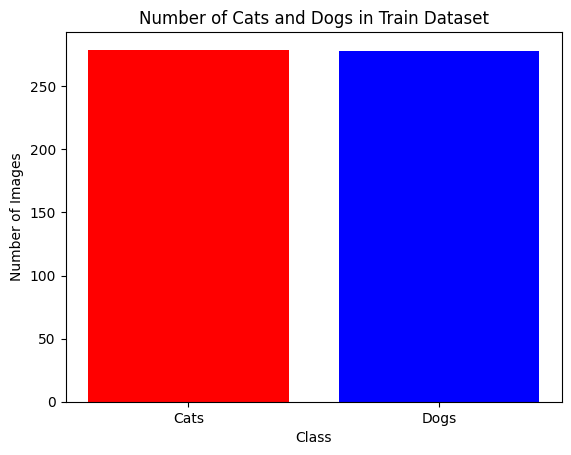

In [ ]:
classes = ['Cats', 'Dogs']
counts = [num_cats, num_dogs]

plt.bar(classes, counts, color = ['red', 'blue'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Cats and Dogs in Train Dataset')
plt.show()

# Data Preparation

In [ ]:
train_data = (train_data.prefetch(tf.data.AUTOTUNE))

In [ ]:
val_data = (val_data.prefetch(tf.data.AUTOTUNE))

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
])

# Model building
Vgg16 is a pre-trained model contining 16 layers. Transfe learning is the method used to build this model making use of Vgg16 model. This enables us to increase the accuract of the model with minimun computational time and power.

---

**VGG16 architecture**: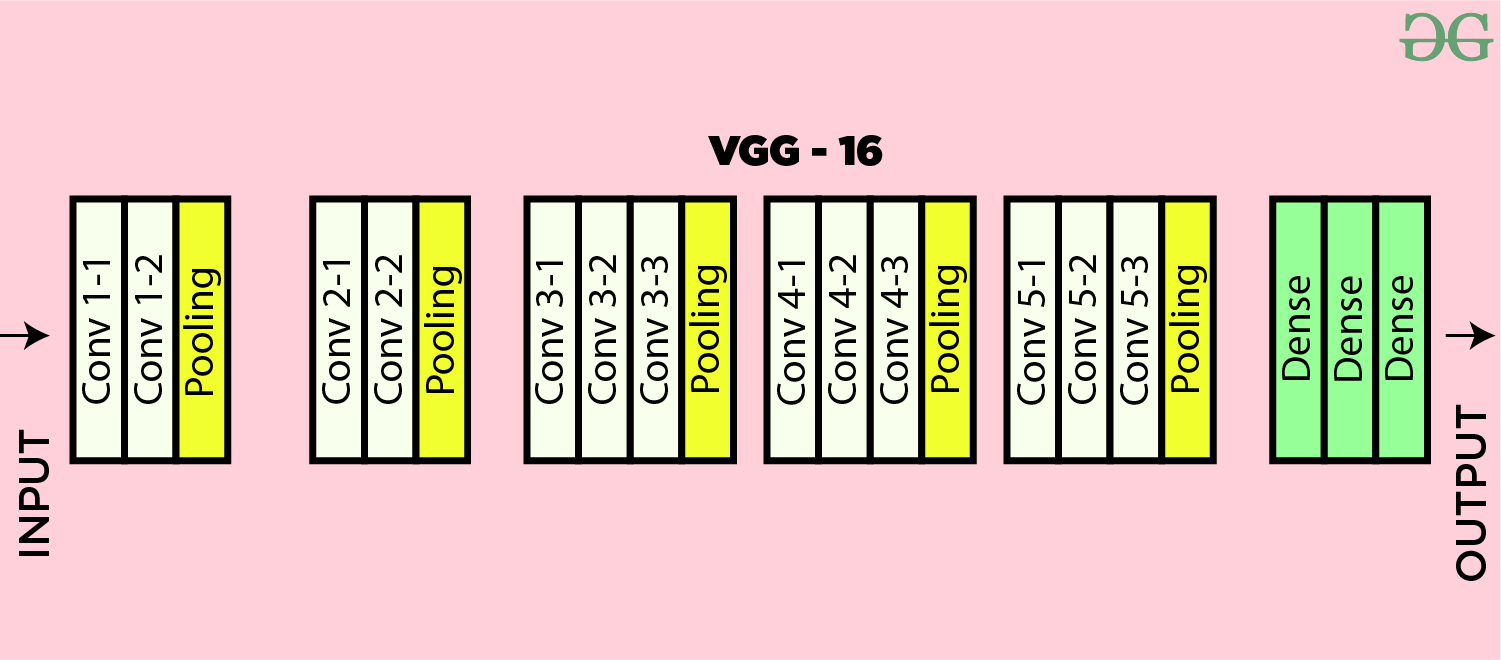




In [ ]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False


model = models.Sequential([
    resize_rescale_layers,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


# Training


In [ ]:
loss_function = BinaryCrossentropy()

In [ ]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 4:
    return lr
  else:
    return lr*0.5

In [ ]:
lr_scheduler = LearningRateScheduler(lambda epoch, lr: learning_rate_scheduler(epoch, lr))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.compile(optimizer= 'adam', loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks = [lr_scheduler, early_stopping])

Epoch 1/10
18/18 [==============================] - 382s 21s/step - loss: 1.5538 - accuracy: 0.6032 - val_loss: 1.0452 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 384s 21s/step - loss: 0.4977 - accuracy: 0.7828 - val_loss: 0.4446 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 370s 21s/step - loss: 0.3030 - accuracy: 0.8761 - val_loss: 0.4266 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - 368s 21s/step - loss: 0.2117 - accuracy: 0.9246 - val_loss: 0.4318 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - 357s 20s/step - loss: 0.1721 - accuracy: 0.9479 - val_loss: 0.4174 - val_accuracy: 0.7929 - lr: 5.0000e-04
Epoch 6/10
18/18 [==============================] - 368s 21s/step - loss: 0.1481 - accuracy: 0.9569 - val_loss: 0.4160 - val_accuracy: 0.7643 - lr: 2.5000e-04
Epoch 7/10
18/18 [==============================] - 368s 21s/s

# Model Evaluation

In [ ]:
evaluation_result = model.evaluate(val_data)
print("Evaluation Result:", evaluation_result)

5/5 [==============================] - 71s 14s/step - loss: 0.3980 - accuracy: 0.7786
Evaluation Result: [0.39795348048210144, 0.7785714268684387]


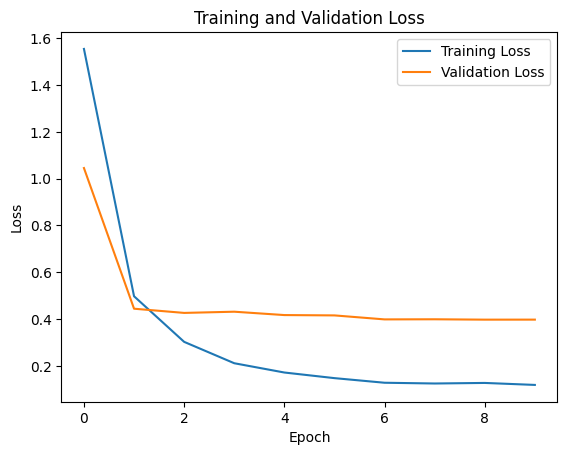

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

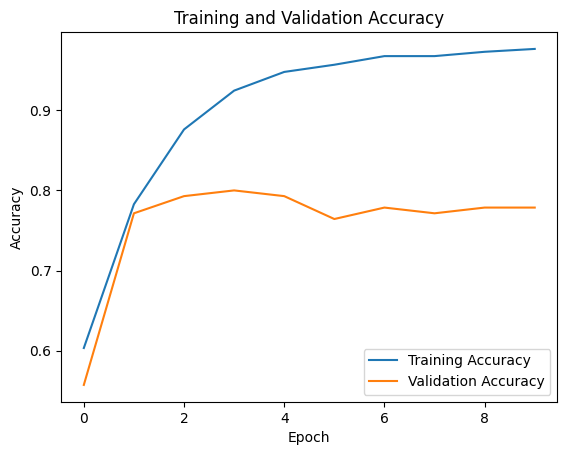

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()